In [8]:
import gym
import random
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from collections import deque
print("Gym:", gym.__version__)
print("Tensorflow:", tf.__version__)

Gym: 0.17.1
Tensorflow: 2.1.0


In [9]:
env_name = "CartPole-v0"
env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(4,)
Action space: Discrete(2)


In [10]:
class QNetwork():
    def __init__(self, state_dim, action_size, tau=0.01):
        tf.reset_default_graph()
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.q_target_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)
        
        self.q_state_local = self.build_model(action_size, "local")
        self.q_state_target = self.build_model(action_size, "target")
        
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state_local, action_one_hot), axis=1)
        self.loss = tf.reduce_mean(tf.square(self.q_state_action - self.q_target_in))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
        
        self.local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="local")
        self.target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target")
        self.updater = tf.group([tf.assign(t, t + tau*(l-t)) for t,l in zip(self.target_vars, self.local_vars)])
        
    def build_model(self, action_size, scope):
        with tf.variable_scope(scope):
            hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
            q_state = tf.layers.dense(hidden1, action_size, activation=None)
            return q_state
        
    def update_model(self, session, state, action, q_target):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target}
        session.run([self.optimizer, self.updater], feed_dict=feed)
        
    def get_q_state(self, session, state, use_target=False):
        q_state_op = self.q_state_target if use_target else self.q_state_local
        q_state = session.run(q_state_op, feed_dict={self.state_in: state})
        return q_state

In [11]:
class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [12]:
class DoubleDQNAgent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.replay_buffer = ReplayBuffer(maxlen=10000)
        self.gamma = 0.97
        self.eps = 1.0
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state)
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.eps else action_greedy
        return action
    
    def train(self, state, action, next_state, reward, done, use_DDQN=True):
        self.replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(50)
        
        next_actions = np.argmax(self.q_network.get_q_state(self.sess, next_states, use_target=False), axis=1)
        q_next_states = self.q_network.get_q_state(self.sess, next_states, use_target=use_DDQN)
        q_next_states[dones] = np.zeros([self.action_size])
        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0]), next_actions]
        q_targets = rewards + self.gamma * q_next_states_next_actions
        self.q_network.update_model(self.sess, states, actions, q_targets)
        
        if done: self.eps = max(0.1, 0.99*self.eps)
    
    def __del__(self):
        self.sess.close()

In [13]:

num_runs = 10
run_rewards = []

for n in range(num_runs):
    print("Run {}".format(n))
    ep_rewards = []
    agent = None
    agent = DoubleDQNAgent(env)
    num_episodes = 200

    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.train(state, action, next_state, reward, done, use_DDQN=(n%2==0))
            #env.render()
            total_reward += reward
            state = next_state

        ep_rewards.append(total_reward)
        #print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
        
    run_rewards.append(ep_rewards)

Run 0
Run 1
Run 2
Run 3
Run 4


KeyboardInterrupt: 

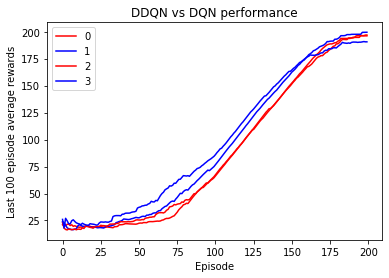

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

for n, ep_rewards in enumerate(run_rewards):
    x = range(len(ep_rewards))
    cumsum = np.cumsum(ep_rewards)
    avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
    col = "r" if (n%2==0) else "b"
    plt.plot(x, avgs, color=col, label=n)
    
plt.title("DDQN vs DQN performance")
plt.xlabel("Episode")
plt.ylabel("Last 100 episode average rewards")
plt.legend()